In [367]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [368]:
# pip install cvxopt
# pip install numdifftools
# pip install scikit-optimize

In [369]:
from skopt import benchmarks as bench

In [430]:
import os
import sys
sys.path.append('..')

import numpy as np
from numpy import linalg
from scipy.optimize import linprog, minimize_scalar
from scipy.stats import norm, chi2
from scipy.linalg import expm
from scipy.integrate import quad

import numdifftools as nd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import lib.LB_convex_optimizer as LB
from lib.functions_plots import PlotTrajectory, PlotConvergence, PlotConvergenceShaded


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

import pickle

In [431]:
import GPy
from safeopt import SafeOpt, SafeOptSwarm
from safeopt import linearly_spaced_combinations, plot_3d_gp
from lib.safeopt_run import run_SafeOpt

# Comparison experiments

In [432]:
def run_exp_SafeOpt(f, h, 
                    d, m,
                    experiments_num = 5, 
                    n_iters = 100,  
                    x00 = np.zeros(2), 
                    x_opt =  np.ones(2) / 2**0.5,  
                    sigma = 0.001,                # noise in measurements
                    bnd = 1,                      # bounds of sampling for SafeOpt
                    problem_name = '',
                    gp_var = 0.01 ):

    errors = []
    cons = []
    for i in range(experiments_num):
        x_traj, errors_so, cons_so, gp = run_SafeOpt(n_iters, 
                                                     f, h, 
                                                     x00, x_opt, 
                                                     d, m, 
                                                     sigma, bnd, gp_var)
        ################ remove if want to run outside of the notebook ##########
#         plt.show()
#         plt.plot(x_traj[:,0], x_traj[:,1], "o")
#         plt.plot(x_traj[-1,0], x_traj[-1,1], "ro")
#         plt.plot(x_opt[0], x_opt[1], "g*")
#         x_size = x_traj.shape[0]
#         plt.show()
        #########################################################################
        print("SafeOptRun finished")
        errors.append(errors_so)
        cons.append(cons_so)
    errors = np.array(errors)
    cons = np.array(cons)
    
    with open('../runs/SafeOpt_' + problem_name + '_d' + str(d)  + '.npy', 'wb') as file:
        np.save(file, errors)
        np.save(file, cons)
    
    return (errors, cons, gp)  

def run_exp_LB_SGD(f, h, d, m,
                   experiments_num = 5, 
                   n_iters = 100, 
                   n = 1, 
                   M0 = 0.5 / 2., 
                   Ms = 0. * np.ones(m), 
                   x00 = np.zeros(2), 
                   x_opt =  np.ones(2) / 2**0.5, 
                   sigma = 0.001, nu = 0.01, 
                   eta0 = 0.05, 
                   T = 3, 
                   factor = 0.85, 
                   init_std = 0.1,
                   problem_name = ''):

    my_oracle = LB.Oracle(
        f = f,
        h = h, 
        sigma = sigma,
        hat_sigma = 0.01,
        delta = 0.01,
        m = m,
        d = d,
        nu = nu,
        zeroth_order = True,
        n = n)

    opt = LB.SafeLogBarrierOptimizer(
        x00 = x00,
        x0 = x00,
        M0 = M0,
        Ms = Ms,
        sigma = my_oracle.sigma,
        hat_sigma = my_oracle.hat_sigma,
        init_std = init_std,
        eta0 = eta0,
        oracle = my_oracle,
        f = f,
        h = h,
        d = d,
        m = m,
        reg = 0.0001,
        x_opt = x_opt,
        factor = factor,
        T = T,
        K = int(n_iters / T / 2. / n),
        experiments_num = experiments_num,
        mu = 0.,
        convex = True,
        random_init = True,
        no_break = True)

    opt.run_average_experiment()
    
    for i in range(experiments_num):
        opt.errors_total[i] = np.repeat(opt.errors_total[i], 2 * n)
        opt.constraints_total[i] = np.repeat(opt.constraints_total[i], 2 * n )
    
    errors = opt.errors_total
    constraints = opt.constraints_total
    
    with open('../runs/LB_SGD_' + problem_name + '_d' + str(d)  + '.npy', 'wb') as file:
        np.save(file, errors)
        np.save(file, constraints)

    return opt

def plot_experiments(d, problem_name):
    with open('../runs/SafeOpt_' + problem_name + '_d' + str(d) + '.npy', 'rb') as file:
        SO_errors = np.load(file)
        SO_cons = np.load(file) 
    with open('../runs/LB_SGD_' + problem_name + '_d' + str(d) + '.npy', 'rb') as file:
        LB_errors = np.load(file)
        LB_cons = np.load(file) 

    PlotConvergenceShaded([LB_errors, SO_errors], 
                          experiments_num, 
                          colors=['blue', 'magenta'], 
                          legends=['LB-SGD', 'SafeOpt' ],
                          figsize=(10, 5),
                          fname = "../runs/objective_" + problem_name +'_d' + str(d),  m = "accuracy")

    shape = np.shape(SO_errors)

    PlotConvergenceShaded([LB_cons, SO_cons, np.zeros(shape)], 
                          experiments_num, 
                          colors=['blue', 'magenta', 'red'], 
                          legends=['LB-SGD', 'SafeOpt','0'],
                          figsize=(10, 5),
                          fname = "../runs/constraints_" + problem_name +'_d' + str(d),  m = "constraints")
    return(0)

## SafeOpt vs LB-SGD on QP

### d = 2

In [433]:
d = 2
m = 2 * d 
x_opt =  np.ones(d) / d**0.5
experiments_num = 10
n = int(d / 2)
n_iters = d * 50
x_opt = np.ones(d) / d**0.5
x00 = np.zeros(d)
M0 = 0.5 / d
Ms = 0. * np.ones(m)
T = 3
sigma = 0.001
problem_name = 'QP'

# constraints
def h(x):
    d = np.size(x)
    A = np.vstack((np.eye(d),-np.eye(d)))
    b = np.ones(2 * d) / d**0.5
    return A.dot(x) - b 

# objective
def f(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
    return np.linalg.norm(x - xx, 2)**2 / 4. / d


In [438]:
(SO_errors2, SO_cons2, gp2) = run_exp_SafeOpt(f, h, d, m,
                                                experiments_num = experiments_num, 
                                                n_iters = n_iters,  
                                                x00 = x00, 
                                                x_opt =  x_opt,  
                                                sigma = sigma,
                                                problem_name = problem_name,
                                                gp_var = 0.01)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


LB_SGD runs finished


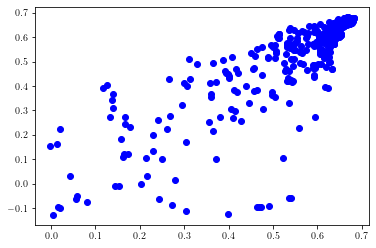

In [422]:
opt2 = run_exp_LB_SGD(f, h, d, m,
                       experiments_num = experiments_num, 
                       n_iters = n_iters,
                       n = n, 
                       M0 = M0, 
                       Ms = Ms, 
                       x00 = x00, 
                       x_opt = x_opt, 
                       sigma = sigma,
                        problem_name = problem_name)

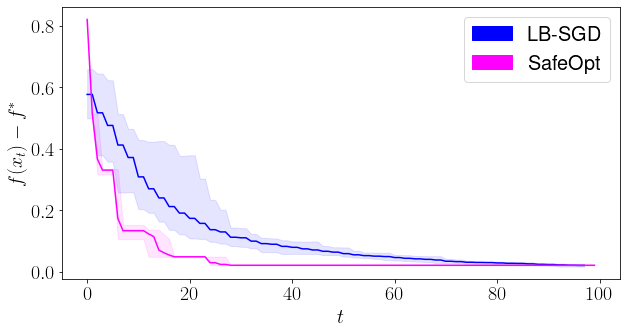

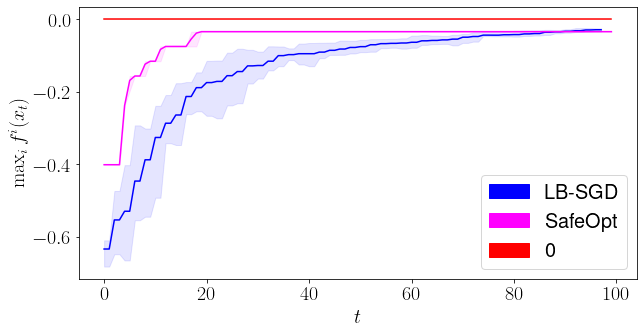

0

In [439]:
plot_experiments(d, problem_name)

### d = 3

In [426]:
d = 3
m = 2 * d 
x_opt =  np.ones(d) / d**0.5
experiments_num = 10
n = int(d / 2)
n_iters = d * 60
x_opt = np.ones(d) / d**0.5
x00 = np.zeros(d)
M0 = 0.5 / d
Ms = 0. * np.ones(m)
T = 3
sigma = 0.001
problem_name = 'QP'

# constraints
def h(x):
    d = np.size(x)
    A = np.vstack((np.eye(d),-np.eye(d)))
    b = np.ones(2 * d) / d**0.5
    return A.dot(x) - b 

# objective
def f(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
    return np.linalg.norm(x - xx, 2)**2 / 4. / d

In [427]:
(SO_errors3, SO_cons3, gp3) = run_exp_SafeOpt(f, h, d, m,
                                                experiments_num = experiments_num, 
                                                n_iters = n_iters,  
                                                x00 = x00, 
                                                x_opt =  x_opt,  
                                                sigma = sigma,
                                                problem_name = problem_name)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


LB_SGD runs finished


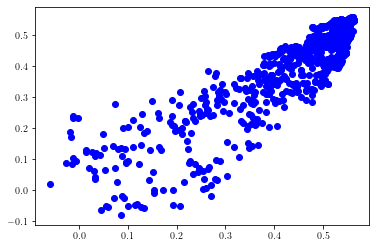

In [428]:
opt3 = run_exp_LB_SGD(f, h, d, m,
                       experiments_num = experiments_num, 
                       n_iters = n_iters,
                       n = n, 
                       M0 = M0, 
                       Ms = Ms, 
                       x00 = x00, 
                       x_opt = x_opt, 
                       sigma = sigma,
                       problem_name = problem_name)

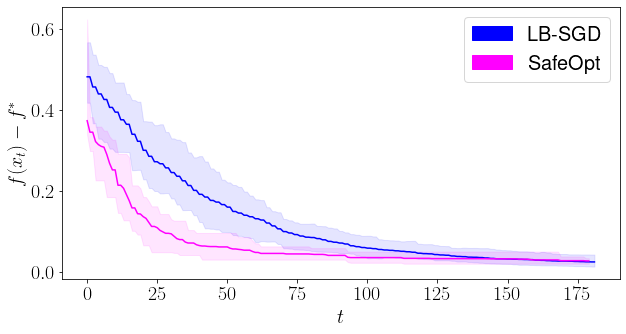

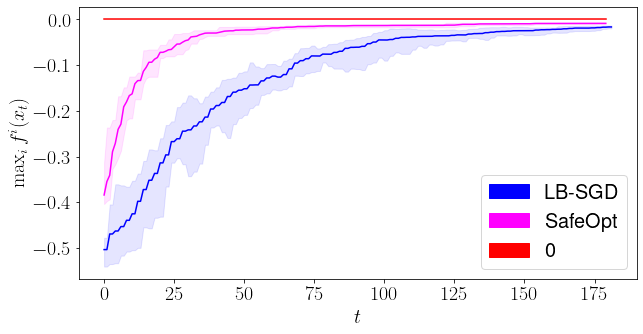

0

In [429]:
plot_experiments(d, problem_name)

### d = 4

In [465]:
d = 4
m = 2 * d 
x_opt =  np.ones(d) / d**0.5
experiments_num = 10
n = int(d / 2)
n_iters = 300
x_opt = np.ones(d) / d**0.5
x00 = np.zeros(d)
M0 = 0.5 / d
Ms = 0. * np.ones(m)
T = 3
sigma = 0.001
problem_name = 'QP'

# constraints
def h(x):
    d = np.size(x)
    A = np.vstack((np.eye(d),-np.eye(d)))
    b = np.ones(2 * d) / d**0.5
    return A.dot(x) - b 

# objective
def f(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
    return np.linalg.norm(x - xx, 2)**2 / 4. / d

In [466]:
(SO_errors4, SO_cons4, gp4) = run_exp_SafeOpt(f, h, d, m,
                                                experiments_num = experiments_num, 
                                                n_iters = n_iters,  
                                                x00 = x00, 
                                                x_opt =  x_opt,  
                                                sigma = sigma,
                                                problem_name = problem_name)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


LB_SGD runs finished


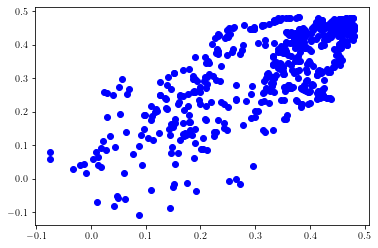

In [467]:
opt4 = run_exp_LB_SGD(f, h, d, m,
                       experiments_num = experiments_num, 
                       n_iters = n_iters,
                       n = n, 
                       M0 = M0, 
                       Ms = Ms, 
                       x00 = x00, 
                       x_opt = x_opt, 
                       sigma = sigma,
                       problem_name = problem_name)

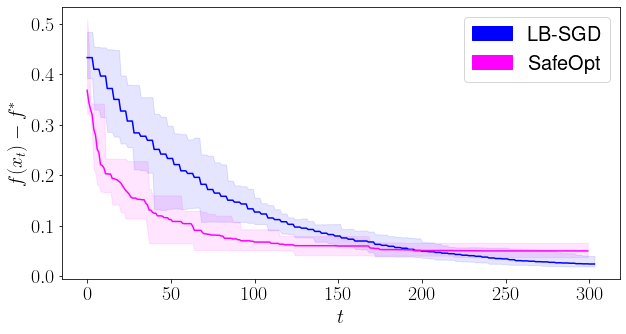

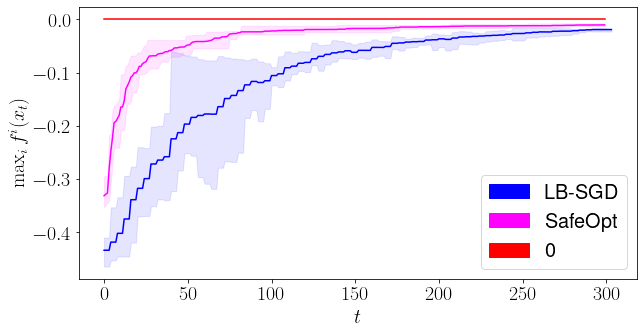

0

In [468]:
plot_experiments(d, problem_name)

# SafeOpt vs LB-SGD on Rosenbrock objective and quadratic constraints

### d = 2

In [440]:
# Rosenbrock fucntion

d = 2
m = 2
experiments_num = 10
n_iters = 100
n = 1
problem_name = 'Rosenbrock'
d = d
M0 = 50.
Ms = 5. * np.ones(m)
x00 = -0.05 * np.ones(d)
x_opt = np.ones(d)
sigma = 0.001
nu = 0.01

def f(x):
#     return np.sin(x[0]) * np.cos(x[1])
    f_rosenbrock = 0.
    for i in range(d - 1):
        f_rosenbrock += 100. * (x[i + 1] - x[i]**2)**2 + (1. - x[i])**2
    return f_rosenbrock

def h(x):
    h1 = np.linalg.norm(x,2)**2 - 1.
    h2 = np.linalg.norm(x + 0.1 * np.ones(d),2)**2 - 2. * 0.1
    return np.array([h1, h2]) 
#     return np.array([(x[0] + 0.1)**2 + (x[1] - 0.1)**2 - 0.2, x[0]**2 + x[1]**2 - 1.])

In [441]:
(SO_errors_r2, SO_cons_r2, gp_r2) = run_exp_SafeOpt(f, h, d, m,
                                                experiments_num = experiments_num, 
                                                n_iters = n_iters,  
                                                x00 = x00, 
                                                x_opt =  x_opt,  
                                                sigma = sigma,
                                                problem_name = problem_name)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


LB_SGD runs finished


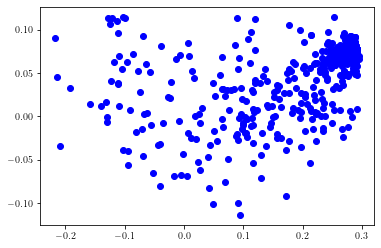

In [442]:
opt_r2 = run_exp_LB_SGD(f, h, d, m,
                       experiments_num = experiments_num, 
                       n_iters = n_iters,
                       n = n, 
                       M0 = M0, 
                       Ms = Ms, 
                       x00 = x00, 
                       x_opt = x_opt, 
                       sigma = sigma,
                       problem_name = problem_name)

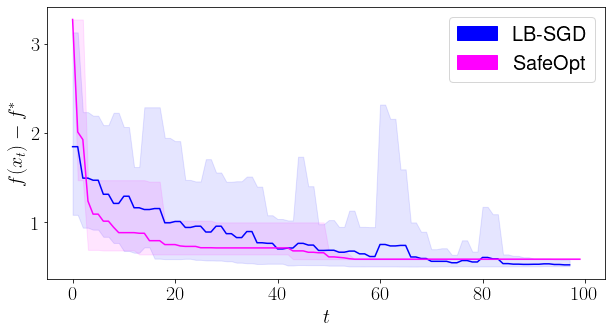

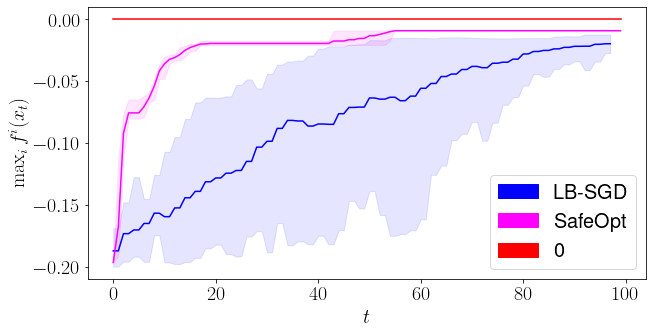

0

In [443]:
plot_experiments(d, problem_name)

In [ ]:
d = 2
bounds = []
for i in range(d):
    bounds.append([-0.5, 0.5])
        
inputs = linearly_spaced_combinations(
        bounds,
        num_samples=10)

plot_3d_gp(gp_r2[0], inputs, predictions=None, figure=None, axis=None, fixed_inputs=None, beta=3)
plot_3d_gp(gp_r2[1], inputs, predictions=None, figure=None, axis=None, fixed_inputs=None, beta=3)
plot_3d_gp(gp_r2[2], inputs, predictions=None, figure=None, axis=None, fixed_inputs=None, beta=3)

### d = 3

In [444]:
d = 3
m = 2
experiments_num = 10
n_iters = 150
n = 2
problem_name = 'Rosenbrock'
M0 = 50.
Ms = 5. * np.ones(m)
x00 = -0.05 * np.ones(d)
x_opt = np.ones(d)
sigma = 0.001
nu = 0.01

def f(x):
#     return np.sin(x[0]) * np.cos(x[1])
    f_rosenbrock = 0.
    for i in range(d - 1):
        f_rosenbrock += 100. * (x[i + 1] - x[i]**2)**2 + (1. - x[i])**2
    return f_rosenbrock

def h(x):
    h1 = np.linalg.norm(x,2)**2 - 1.
    h2 = np.linalg.norm(x + 0.1 * np.ones(d),2)**2 - 2. * 0.1
    return np.array([h1, h2]) 

In [445]:
(SO_errors_r3, SO_cons_r3, gp_r3) = run_exp_SafeOpt(f, h, d, m,
                                                experiments_num = experiments_num, 
                                                n_iters = n_iters,  
                                                x00 = x00, 
                                                x_opt =  x_opt,  
                                                sigma = sigma,
                                                problem_name = problem_name)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


LB_SGD runs finished


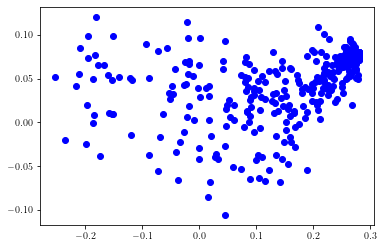

In [446]:
opt_r3 = run_exp_LB_SGD(f, h, d, m,
                       experiments_num = experiments_num, 
                       n_iters = n_iters,
                       n = n, 
                       M0 = M0, 
                       Ms = Ms, 
                       x00 = x00, 
                       x_opt = x_opt, 
                       sigma = sigma,
                       problem_name = problem_name)

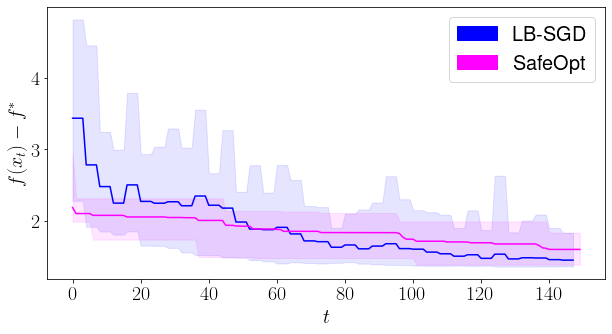

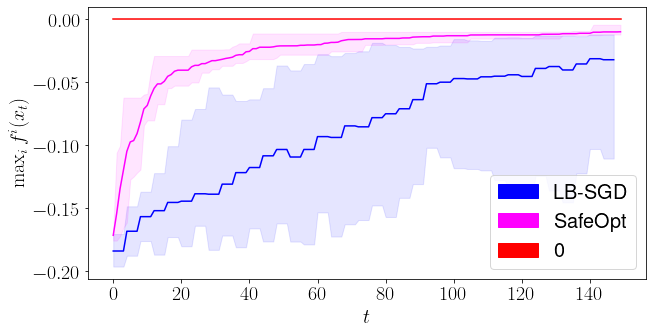

0

In [447]:
plot_experiments(d, problem_name)

### d = 4

In [469]:
d = 4
m = 2
experiments_num = 10
n_iters = 200
n = 2
problem_name = 'Rosenbrock'
bnd = 1.
M0 = 70.
Ms = 7. * np.ones(m)
x00 = -0.05 * np.ones(d)
x_opt = np.ones(d)
sigma = 0.001
nu = 0.01

def f(x):
    f_rosenbrock = 0.
    for i in range(d - 1):
        f_rosenbrock += 100. * (x[i + 1] - x[i]**2)**2 + (1. - x[i])**2
    return f_rosenbrock

def h(x):
    h1 = np.linalg.norm(x,2)**2 - 1.
    h2 = np.linalg.norm(x + 0.1 * np.ones(d),2)**2 - 2. * 0.1
    return np.array([h1, h2]) 

In [470]:
(SO_errors_r4, SO_cons_r4, gp_r4) = run_exp_SafeOpt(f, h, d, m,
                                                experiments_num = experiments_num, 
                                                n_iters = n_iters,  
                                                x00 = x00, 
                                                x_opt =  x_opt,  
                                                sigma = sigma,
                                                problem_name = problem_name,
                                                bnd = bnd)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


LB_SGD runs finished


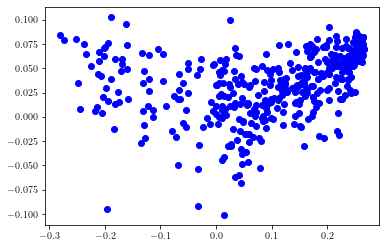

In [471]:
opt_r4 = run_exp_LB_SGD(f, h, d, m,
                       experiments_num = experiments_num, 
                       n_iters = n_iters,
                       n = n, 
                       M0 = M0, 
                       Ms = Ms, 
                       x00 = x00, 
                       x_opt = x_opt, 
                       sigma = sigma,
                       problem_name = problem_name)

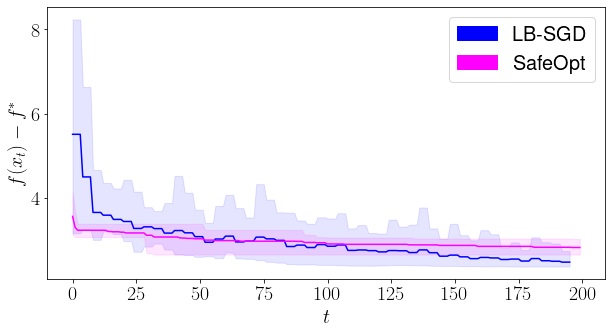

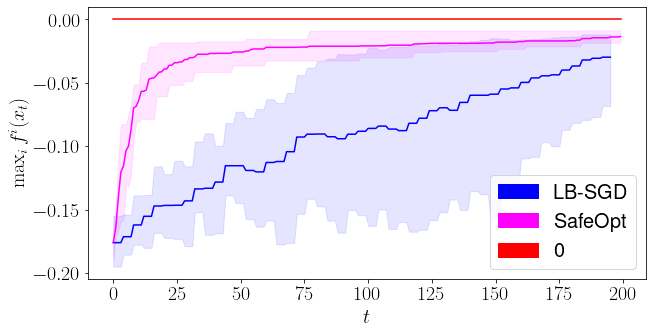

0

In [472]:
plot_experiments(d, problem_name)

# Negative Gaussian objective and quadratic constraint

### (comparison with LineBO for high dimensions, LineBO runs separately, in progress)

In [389]:
import h5py

In [ ]:
def read_LineBO(file):
    ysss = []
    xsss = []
    ysss_min = []
    ysss_exact = []
    zsss_exact = []
    for j in range(3):
        xss = []
        yss = []
        yss_min = []
        yss_exact = []
        zss_exact = []
        for i in range(10):
            xs = []
            ys = []
            ys_min = []
            ys_exact = []
            zs_exact = []
            y_min = 10.
            for g in file[str(j)][str(i)]:
                xs.append(g['x'])
    #             print(g['x'], g['s'])
                ys.append(g['y'])
                ys_exact.append(g['y_exact'])
    #             zs_exact.append(g['s'])
    #             for i in range(np.size(g['s'])):
                y_min = min(-g['y_exact'], y_min)
                ys_min.append(y_min)

            xs = np.array(xs)
            ys = np.array(ys)
            ys_exact = np.array(ys_exact)
            ys_min = np.array(ys_min)
    #         zs_exact = np.array(zs_exact)
            xss.append(xs)
            yss.append(ys)
            yss_exact.append(ys_exact)
            yss_min.append(ys_min)
    #         zss_exact.append(zs_exact)

        yss = np.array(yss)
        xss = np.array(xss)
        yss_exact = np.array(yss_exact)
        yss_min = np.array(yss_min)
    #     zss_exact = np.array(zss_exact)

        ysss_exact.append(yss_exact)
        ysss_min.append(yss_min)
        xsss.append(xss)
    #     zsss_exact.append(zss_exact)
    return (ysss_exact, ysss_min, xsss)

### d = 2

In [ ]:
file = h5py.File('/Users/ilnura/libs/LineBO/runs/Gaussian_2_constraint/data/evaluations.hdf5', 'r')
(ys_exact, ys_min, xs) = read_LineBO(file)

In [ ]:
d = 2
m = 2 
experiments_num = 10
n_iters = d * 100
# n_iters = 200
x_opt = np.zeros(d) / d**0.5
x0 = d**(-1) * np.ones(d)
# x0 = d**(-0.5) * np.ones(d)
# x0[0] = 0.

n = int(d / 2)
M0 = 30.
Ms = d**2 * 0.5 * np.ones(m)
T = 3
problem_name = 'Gaussian'

"""
Gaussian benchmark function with quadratic constraint.
"""
def h(X):
    r = d**(-0.5)
    x0 = d**(-0.5) * np.ones(d)
    h = np.linalg.norm(X - x0)**2 - r**2 + d**2 * (X[1] - x0[1])**2
    return np.array([h , h - 10.])
 
def f(X):
    Y = np.exp(-4 * np.linalg.norm(X,2)**2)
    return -Y

In [ ]:
opt_g2 = run_exp_LB_SGD(f, h, d, m,
                       experiments_num = experiments_num, 
                       n_iters = n_iters,
                       n = n, 
                       M0 = M0, 
                       Ms = Ms, 
                       x00 = x00, 
                       x_opt = x_opt, 
                       sigma = sigma,
                       problem_name = problem_name)

In [ ]:
with open('../runs/LB_SGD_' + problem_name + '_d' + str(d) + '.npy', 'rb') as file:
        LB_errors = np.load(file)
        LB_cons = np.load(file) 

shape = np.shape(SO_errors)
opt_val = 1
PlotConvergenceShaded([ys_min[0]
                       ,ys_min[1]
                       ,ys_min[2]
                       ,LB_errors - opt_val * np.ones(shape)
#                        ,np.zeros(shape)
                      ], 
                      10, 
                      colors=['blue' 
                              ,'orange'
                              ,'green'
                              ,'magenta'
                             ], 
                      legends=['RandomLineBO' 
                               ,'CoordinateLineBO' 
                               ,'DescentLineBO'
                               ,'LBSGD'
                              ],
                      figsize=(10, 5),
                      fname = "../runs/objective_" + problem_name +'_d' + str(d),  m = "accuracy")

### d = 10

In [ ]:
d = 10
m = 2 
experiments_num = 10
n_iters = d * 100
# n_iters = 200
x_opt = np.zeros(d) / d**0.5
x0 = d**(-1) * np.ones(d)
# x0 = d**(-0.5) * np.ones(d)
# x0[0] = 0.

n = int(d / 2)
M0 = 30.
Ms = d**2 * 0.5 * np.ones(m)
T = 3
problem_name = 'Gaussian'
"""
Gaussian benchmark function with quadratic constraint.
"""
def h(X):
    r = d**(-0.5)
    x0 = d**(-0.5) * np.ones(d)
    h = np.linalg.norm(X - x0)**2 - r**2 + d**2 * (X[1] - x0[1])**2
    return np.array([h , h - 10.])
 
def f(X):
    Y = np.exp(-4 * np.linalg.norm(X,2)**2)
    return -Y

In [ ]:
opt_g10 = run_exp_LB_SGD(f, h, d, m,
                       experiments_num = experiments_num, 
                       n_iters = n_iters,
                       n = n, 
                       M0 = M0, 
                       Ms = Ms, 
                       x00 = x00, 
                       x_opt = x_opt, 
                       sigma = sigma,
                       problem_name = problem_name)

In [ ]:
file = h5py.File('/Users/ilnura/libs/LineBO/runs/Gaussian_10_constraint/data/evaluations.hdf5', 'r')
(ys_exact, ys_min, xs) = read_LineBO(file)

In [ ]:
with open('../runs/LB_SGD_' + problem_name + '_d' + str(d) + '.npy', 'rb') as file:
        LB_errors = np.load(file)
        LB_cons = np.load(file) 

shape = np.shape(SO_errors)
opt_val = 1
PlotConvergenceShaded([ys_min[0]
                       ,ys_min[1]
                       ,ys_min[2]
                       ,LB_errors - opt_val * np.ones(shape)
#                        ,np.zeros(shape)
                      ], 
                      10, 
                      colors=['blue' 
                              ,'orange'
                              ,'green'
                              ,'magenta'
                             ], 
                      legends=['RandomLineBO' 
                               ,'CoordinateLineBO' 
                               ,'DescentLineBO'
                               ,'LBSGD'
                              ],
                      figsize=(10, 5),
                      fname = "../runs/objective_" + problem_name +'_d' + str(d),  m = "accuracy")

# EVERYTHING BELOW IS NOT UPDATED (I save them to remember hyperparametersc parameters)

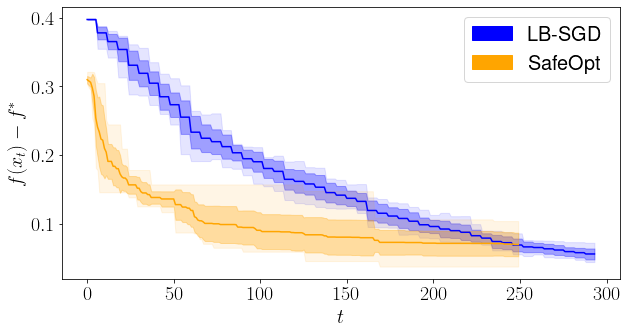

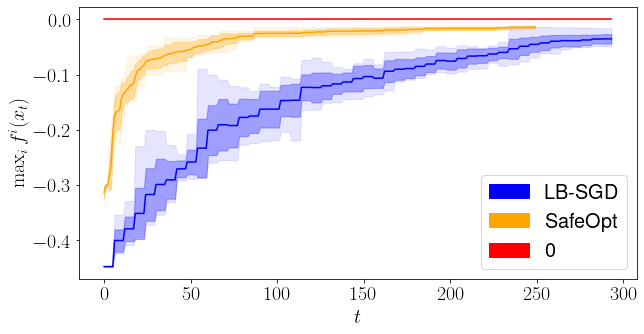

0

In [52]:
PlotConvergenceShaded([opt5.errors_total, errors_SO_d5], 
                      opt5.experiments_num, 
                      colors=['blue', 'orange'], 
                      legends=['LB-SGD', 'SafeOpt'],
                      figsize=(10, 5),
                      fname = "objective_QP_d5",  m = "accuracy")

shape = np.shape(opt5.constraints_total)

PlotConvergenceShaded([opt5.constraints_total, cons_SO_d5, np.zeros(shape)], 
                      opt5.experiments_num, 
                      colors=['blue', 'orange', 'red'], 
                      legends=['LB-SGD', 'SafeOpt', '0'],
                      figsize=(10, 5),
                      fname = "constraints_QP_d5",  m = "constraints")

Finished


array([0.47621496, 0.48297412, 0.46465997, 0.48672568])

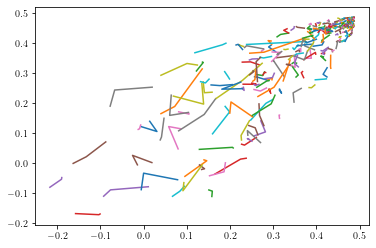

In [402]:
d = 4
m = 2 * d 
experiments_num = 10
n_iters = 400
x_opt = np.ones(d) / d**0.5
x0 = np.zeros(d)

n = 2
M0 = 0.5 / d
Ms = 0. * np.ones(m)
T = 3

my_oracle3 = LB.Oracle(
    f = f,
    h = h, 
    sigma = 0.001,
    hat_sigma = 0.01,
    delta = 0.01,
    m = m,
    d = d,
    nu = 0.01,
    zeroth_order = True,
    n = n)

opt3 = LB.SafeLogBarrierOptimizer(
    x00 = x0,
    x0 = x0,
    M0 = M0,
    Ms = Ms,
    sigma = my_oracle3.sigma,
    hat_sigma = my_oracle3.hat_sigma,
    init_std = 0.2,
    eta0 = 0.05,
    oracle = my_oracle3,
    f = f,
    h = h,
    d = d,
    m = m,
    reg = 0.0001,
    x_opt = x_opt,
    factor = 0.85,
    T = T,
    K = int(n_iters / T / 2. / n),
#         factor = 0.5,
#         T = 100,
#         K = 4,
    experiments_num = experiments_num,
    mu = 0.,
    convex = True,
    random_init = True,
    no_break = True)

opt3.run_average_experiment()

for i in range(experiments_num):
    opt3.errors_total[i] = np.repeat(opt3.errors_total[i], 2 * n)
    opt3.constraints_total[i] = np.repeat(opt3.constraints_total[i], 2 * n )

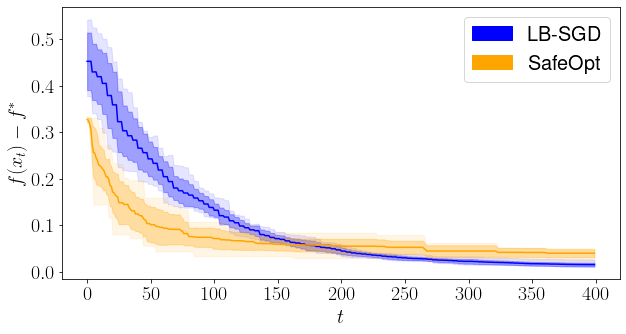

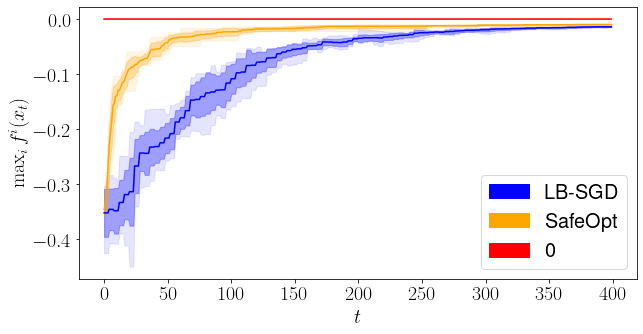

0

In [660]:
PlotConvergenceShaded([opt3.errors_total, errors_SO_d4], 
                      opt3.experiments_num, 
                      colors=['blue', 'orange'], 
                      legends=['LB-SGD', 'SafeOpt'],
                      figsize=(10, 5),
                      fname = "objective_QP_d4",  m = "accuracy")

shape = np.shape(opt3.constraints_total)

PlotConvergenceShaded([opt3.constraints_total, cons_SO_d4, np.zeros(shape)], 
                      opt3.experiments_num, 
                      colors=['blue', 'orange', 'red'], 
                      legends=['LB-SGD', 'SafeOpt', '0'],
                      figsize=(10, 5),
                      fname = "constraints_QP_d4",  m = "constraints")

In [169]:
# d = 6

# x00 = np.array([0.1335990371483741, 0.2743781816448671, 0.2879962344461537,  
#                 0.10242147970254536, 0.3959197145814795, 0.5982863622683936])
# x_opt = np.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652,  0.6573])
# x00 = np.ones(d) * 0.5

# L = 1.
# M0 = 0.1
# m = np.size(g(x00))
# Ms = 0.1 * np.ones(m)
# eta0 = 0.025
# mu = 1

# T = int(20 * d)
# experiments_num = 20
# num_samples = 1
# sigma = 0.05
# reg = 2
# de = 0.01
# nu = 0.01
# K = 2
# # S = int(10*d**0.5)
# S = 1
# V = 1

# x00 = get_random_initial_point(g, x00)


NameError: name 'g' is not defined

In [185]:
# Hartmann and Hartmann
def f(x):
    return bench.hart6(x)
def h(x):
    return f(x) + 0.1
d = 6
m = 1
x_opt = np.array([0.20169, 0.150011, 0.476874, 
                  0.275332, 0.311652,  0.6573])
M0 = 5.
Ms = np.ones(m) * 5.
x0 = np.array([0.1335990371483741, 0.2743781816448671, 
               0.2879962344461537, 0.10242147970254536, 
               0.3959197145814795, 0.5982863622683936])
x0 = np.ones(d) * 0.2

#         if self.d == 6:
#             x0_det = np.array([0.1335990371483741, 0.2743781816448671, 
#                                0.2879962344461537, 0.10242147970254536, 
#                                0.3959197145814795, 0.5982863622683936])
#         else:
#             x0_det = 0.4 * np.ones(self.d)

# LineBO with constraint

## Gaussian 10 Quadratic Constraint

In [ ]:
file = h5py.File('/Users/ilnura/libs/LineBO/runs/Gaussian_2_constraint/data/evaluations.hdf5', 'r')
(ysss_exact, ysss_min, xsss) = read_LineBO(file)

LB_SGD runs finished


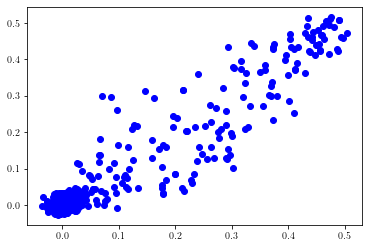

In [394]:
d = 2
m = 2 
experiments_num = 10
n_iters = d * 100
# n_iters = 200
x_opt = np.zeros(d) / d**0.5
# x0 = d**(-1) * np.ones(d)
x0 = d**(-0.5) * np.ones(d)
# x0[0] = 0.

n = int(d / 2)
M0 = 30.
Ms = d**2 * 0.5 * np.ones(m)
T = 3

"""
Gaussian benchmark function with quadratic constraint.
"""
def h(X):
    r = d**(-0.5)
    x0 = d**(-0.5) * np.ones(d)
    h = np.linalg.norm(X - x0)**2 - r**2 + d**2 * (X[1] - x0[1])**2
    return np.array([h - 20. , h - 10.])
 
def f(X):
#     X = np.atleast_2d(X)
#     Y = np.exp(-4 * np.sum(np.square(X), axis=1))
    Y = np.exp(-4 * np.linalg.norm(X,2)**2)
    return -Y


my_oracle3 = LB.Oracle(
    f = f,
    h = h, 
    sigma = 0.001,
    hat_sigma = 0.01,
    delta = 0.01,
    m = m,
    d = d,
    nu = 0.01,
    zeroth_order = True,
    n = n)

opt3 = LB.SafeLogBarrierOptimizer(
    x00 = x0,
    x0 = x0,
    M0 = M0,
    Ms = Ms,
    sigma = my_oracle3.sigma,
    hat_sigma = my_oracle3.hat_sigma,
    init_std = 0.,
    eta0 = 0.1,
    oracle = my_oracle3,
    f = f,
    h = h,
    d = d,
    m = m,
    reg = 0.0001,
    x_opt = x_opt,
    factor = 0.9,
    T = T,
    K = int(n_iters / T / 2. / n),
    experiments_num = experiments_num,
    mu = 0.,
    convex = True,
    random_init = True,
    no_break = True)

opt3.run_average_experiment()

for i in range(experiments_num):
    opt3.errors_total[i] = np.repeat(opt3.errors_total[i], 2 * n)
    opt3.constraints_total[i] = np.repeat(opt3.constraints_total[i], 2 * n )

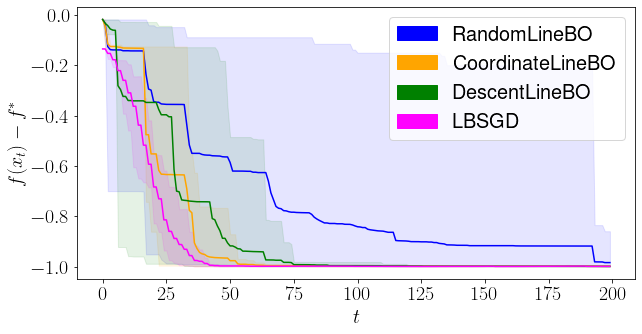

0

In [395]:
shape = np.shape(opt3.errors_total)
PlotConvergenceShaded([ysss_min[0]
                       ,ysss_min[1]
                       ,ysss_min[2]
                       ,opt3.errors_total - np.ones(shape)
#                        ,np.zeros(shape)
                      ], 
                      10, 
                      colors=['blue' 
                              ,'orange'
                              ,'green'
                              ,'magenta'
                             ], 
                      legends=['RandomLineBO' 
                               ,'CoordinateLineBO' 
                               ,'DescentLineBO'
                               ,'LBSGD'
                              ],
                      figsize=(10, 5),
                      fname = "obj_linebo",  m = "accuracy")

In [274]:
x = [-0.13353719, -0.13773307] 
# [-4.17728314]
def h(X):
    d = np.size(X)
    r = d**(-0.5)
    x0 = d**(-0.5) * np.ones(d)
    h = np.linalg.norm(X - x0)**2 - r**2 + d**2 * (X[1] - x0[1])**2
    return -h

print(h(x))

-3.7754541570568283
